In [1]:
!pip install mne
!pip install EDFlib-Python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd 
import mne

In [3]:
data = pd.read_csv('recording.txt', delimiter = ",", header = None)
print(data.shape)

data = data.iloc[:, 1:9]

(149746, 25)


In [4]:
#data = pd.read_csv('A.csv', delimiter = "\t", header = None)# .iloc[:,1:9]

print(data.shape)
data.head()

(149746, 8)


,1,2,3,4,5,6,7,8
0,4125.416771,20708.310092,198.863470,-2136.670308,2.783188e+06,7469.729480,2.781326e+06,-187500.022352
1,4120.789960,20711.886372,196.494186,-2142.749982,2.783104e+06,7455.849046,2.781387e+06,-187500.022352
2,4081.562648,20705.449069,186.949991,-2149.053174,2.782839e+06,7487.856744,2.783676e+06,-187500.022352
3,4088.804613,20700.039947,192.850851,-2142.370003,2.782607e+06,7506.274582,2.785442e+06,-187500.022352
4,4103.713227,20700.643444,195.331895,-2141.230064,2.782491e+06,7488.594352,2.785924e+06,-187500.022352


In [5]:
ch_names = ['Fp1', 'Fp2', 'C1', 'C2', 'P7', 'P8', 'O1', 'O2']

sfreq = 250 
info = mne.create_info(ch_names = ch_names, sfreq = sfreq)
info['experimenter'] = 'Michael Huang, Adan Montes de Oca, Sripad Karne'

raw = mne.io.RawArray(data.transpose(), info)
raw

Creating RawArray with float64 data, n_channels=8, n_times=149746
    Range : 0 ... 149745 =      0.000 ...   598.980 secs
Ready.


<RawArray | 8 x 149746 (599.0 s), ~9.2 MB, data loaded>

Using matplotlib as 2D backend.


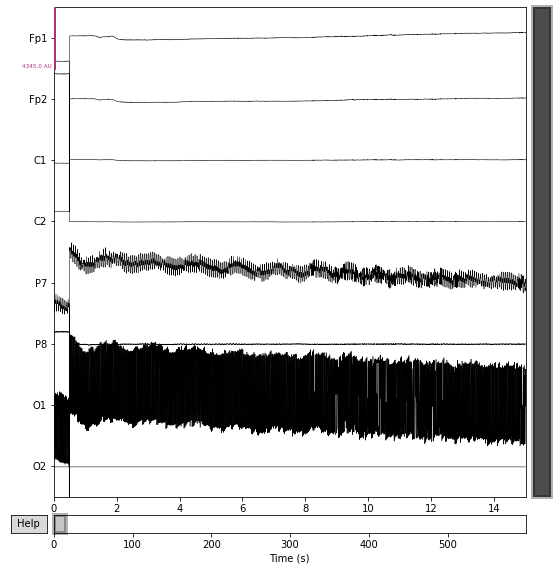

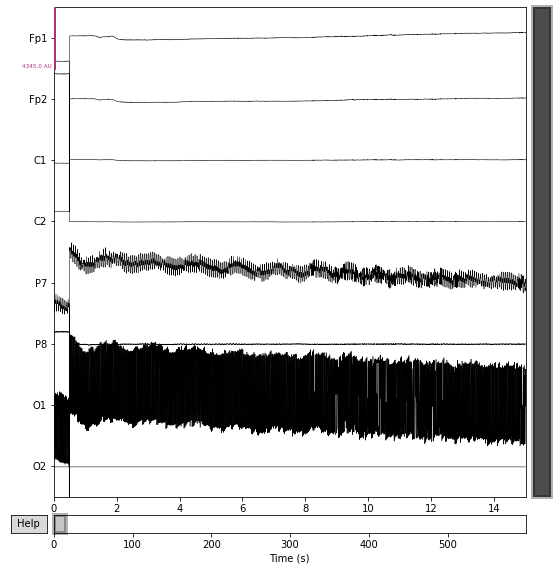

In [6]:
raw.plot(duration = 15, start=0)

In [7]:
med_annotations = mne.Annotations(onset=[52.28, 121.78, 168.14, 210.50, 249.94, 297.32, 329.55, 406.04, 450.62, 483.01, 553.49],  # in seconds
                           duration= np.repeat(15, 11),  # in seconds, too
                           description=['333', '242', '342','243', '223', '333','432', '443', '233','233', '233'])
print(med_annotations)

raw.set_annotations(med_annotations)

<Annotations | 11 segments: 223 (1), 233 (3), 242 (1), 243 (1), 333 (2), ...>


<RawArray | 8 x 149746 (599.0 s), ~9.2 MB, data loaded>

In [8]:
raw.annotations.save('meditation-annotations.csv', overwrite=True)
pd.read_csv('meditation-annotations.csv')

Overwriting existing file.


,onset,duration,description
0,1970-01-01 00:00:52.280,15.0,333
1,1970-01-01 00:02:01.780,15.0,242
2,1970-01-01 00:02:48.140,15.0,342
3,1970-01-01 00:03:30.500,15.0,243
4,1970-01-01 00:04:09.940,15.0,223
5,1970-01-01 00:04:57.320,15.0,333
6,1970-01-01 00:05:29.550,15.0,432
7,1970-01-01 00:06:46.040,15.0,443
8,1970-01-01 00:07:30.620,15.0,233
9,1970-01-01 00:08:03.010,15.0,233


In [9]:
mne.export.export_raw('meditation.edf',raw, fmt='edf', overwrite = True)

Overwriting existing file.


<ipython-input-9-6b87a449d098>:1: RuntimeWarning: EDF format requires equal-length data blocks, so 0.016 seconds of zeros were appended to all channels when writing the final block.
  mne.export.export_raw('meditation.edf',raw, fmt='edf', overwrite = True)
